# Analysis

In this notebook, I will work on data normalization and feature selection (highly variable gene selection) in scRNA-seq data. I will load the saved processed data and proceed.


## Load necessary packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

## Load the processed data (see session-1 for the file)

In [3]:
adata = sc.read_h5ad('/Users/sangeevanvellappan/Desktop/scRNA/processed_adata.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 13350 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

# Data normalization

A note based on what I have learned so far: "A common artefact in data analysis is to have cellular heterogeneity strongly correlated with sequencing depth. This can be observed by visualizing library size on a low-dimensional representation of the data (UMAP or tSNE). Since we assume that the majority of biological variation should not be driven by sequencing depth bias, it is of interest to address this issue by normalizing the cells".
I will use the median library size normalization. 

## Median Library Size Normalization

Notes: "One of the most common normalization methods is median library size normalization followed by log-transformation. Median library size normalization is inspired by normalization techniques in bulk data (Transcript Per Million or TPM normalization). This approach aims to normalize the library size of all cells to the same value, which is usually set to be the median library size in the data. The assumption here is that all cells in a sample should have the same total number of RNA counts. Obviously this is not necessarily an adequate assumption and in many circumstances is false (for example, a sample with cells of different sizes or at different stages of activation can have different total RNA). However, this is still the most common kind of normalization being used. 
The normalization step is followed by a log transformation of the data. This step is done primarily to normalize for the differences in gene expression scales. Of note, scRNA-seq data is massively undersampled, which means many of the entries are 0 thus taking log of the data can be problematic. As such, it is typical to add a non-zero pseudocount (typically 0.1 or 1) to the data. It is generally wise to ensure that zeros remain as zeros post log-transformation. So, it is common to add 1 to the data before taking log2 of the data: `adata.X = np.log2(adata.X + 1)` or adding and subtracting 0.1: `adata.X = np.log(adata.X + 0.1) - np.log(0.1)`. Either way, zeros before log remain as zeros".

"Before we apply this normalization step, one very important note on Scanpy's data structure: The main data on which processing is to be done is stored in adata.X. So if we normalize the data in place then the original raw data will be replaced by the new normalized counts and we will lose the original counts. To avoid this from happening, we will store the original raw counts in adata.layers as follows. It is wise to save original counts for later, as we may require them for downstream analysis (e.g. count based factor analysis methods)".

### Option 1: Save in layers

In [5]:
adata.layers['raw_data'] = adata.X.copy()

In [6]:
adata

AnnData object with n_obs × n_vars = 13350 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'raw_data'

### Option 2: Save in raw

In [7]:
adata.raw = adata

In [8]:
adata.raw

Now that we have made a copy of the original counts, we can go ahead and apply Scanpy's normalization function.

In [9]:
sc.pp.normalize_total(adata, inplace = True)

In [10]:
adata

AnnData object with n_obs × n_vars = 13350 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'raw_data'

An extra step: Before we take log of the normalized counts, we can save the normalized counts in layers (just like we did for the original counts).

In [11]:
adata.layers['norm_counts'] = adata.X.copy()

In [12]:
adata

AnnData object with n_obs × n_vars = 13350 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'raw_data', 'norm_counts'

We can now log transform the data as follows:

In [13]:
sc.pp.log1p(adata)

In [14]:
adata

AnnData object with n_obs × n_vars = 13350 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'raw_data', 'norm_counts'

In [15]:
adata.X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.58102417, ..., 0.        , 0.        ,
        0.3321302 ],
       [0.        , 0.5486806 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

# Highly Variable Genes

In [21]:
#based on the methods of the paper:  Feature selection was then performed to select the top 2500 most highly variable genes (using scanpy.pp.highly_variable_genes), which was used as input for principal component analysis with 50 components.

sc.pp.highly_variable_genes(adata, layer = 'raw_data', n_top_genes = 2500, flavor = 'seurat_v3')

In [17]:
adata

AnnData object with n_obs × n_vars = 13350 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_data', 'norm_counts'

In [18]:
adata.var[['highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm']]

,highly_variable,highly_variable_rank,means,variances,variances_norm
AL627309.5,False,NaN,0.004719,0.004697,0.907155
LINC01409,False,NaN,0.100449,0.123327,0.941704
LINC01128,False,NaN,0.060749,0.069648,0.899779
LINC00115,False,NaN,0.003820,0.003806,0.942366
FAM41C,False,NaN,0.014307,0.015152,0.871649
...,...,...,...,...,...
AC011043.1,False,NaN,0.017678,0.019614,0.909747
AL592183.1,False,NaN,0.105993,0.129524,0.932036
AC240274.1,False,NaN,0.011536,0.012003,0.863019
AC004556.3,False,NaN,0.153633,0.183377,0.872831


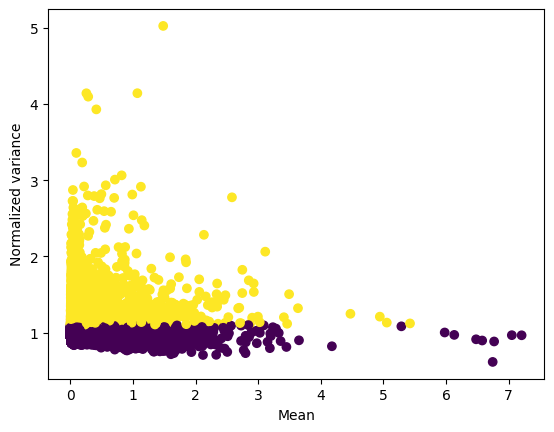

In [19]:
x = adata.var['means']
y = adata.var['variances_norm']

colors = adata.var['highly_variable']

plt.scatter(np.log2(x + 1), np.log2(y + 1), c=colors)
plt.xlabel('Mean')
plt.ylabel('Normalized variance')
plt.show()

# PCA

In [22]:
# PCA- also component value is based on the methods mentioned in the paper
sc.tl.pca(adata, n_comps=50, use_highly_variable=None)

# 5. GRAPH

In [23]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')

/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
adata

AnnData object with n_obs × n_vars = 13350 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

In [25]:
adata.obsp['neighbors_30_distances']

<13350x13350 sparse matrix of type '<class 'numpy.float32'>'
	with 413850 stored elements in Compressed Sparse Row format>

In [26]:
adata.obsp['neighbors_30_connectivities']

<13350x13350 sparse matrix of type '<class 'numpy.float32'>'
	with 589692 stored elements in Compressed Sparse Row format>

# UMAP

In [27]:
sc.tl.umap(adata, neighbors_key = 'neighbors_30', min_dist=0.1)

In [28]:
adata

AnnData object with n_obs × n_vars = 13350 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

In [29]:
adata.obsm['X_umap']

array([[-2.0258296 ,  4.0872116 ],
       [10.599785  ,  2.0307114 ],
       [11.630317  ,  4.358819  ],
       ...,
       [-1.9165324 ,  2.4875934 ],
       [11.01571   , -0.04420216],
       [ 5.627225  ,  5.721436  ]], dtype=float32)

In [30]:
adata.obsm['X_umap'].shape

(13350, 2)

In [31]:
adata_umap_temp = sc.tl.umap(adata, neighbors_key = 'neighbors_30', copy = True)
adata.obsm['umap_30_knn'] = adata_umap_temp.obsm['X_umap']
del adata_umap_temp

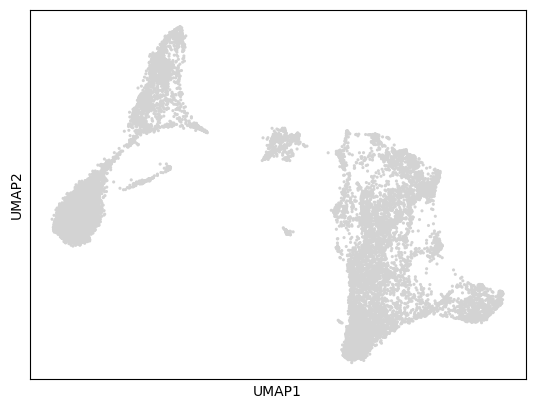

In [32]:
sc.pl.umap(adata, size = 20)

In [33]:
# Nearest neighbors on PCA
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')

In [34]:
# UMAP, FDL using the nearest neighbors
sc.tl.umap(adata, neighbors_key = 'neighbors_30', min_dist=0.1)
sc.tl.draw_graph(adata, layout='fa', random_state=0, neighbors_key='neighbors_30')

In [35]:
# Clustering using PhenoGraph
sc.external.tl.phenograph(adata, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter = 0.5)

import scipy
adata.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adata.obsp['pheno_jaccard_ig'])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8088829517364502 seconds
Jaccard graph constructed in 4.921982288360596 seconds
Running Leiden optimization
Leiden completed in 3.9172661304473877 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 11.495551109313965 seconds


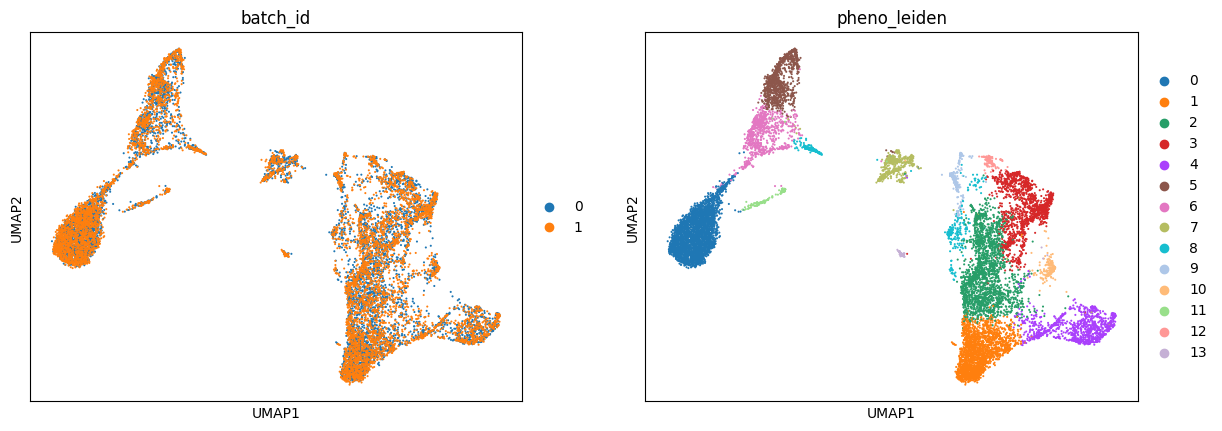

In [36]:
sc.pl.umap(adata, color = ['batch_id', 'pheno_leiden'])

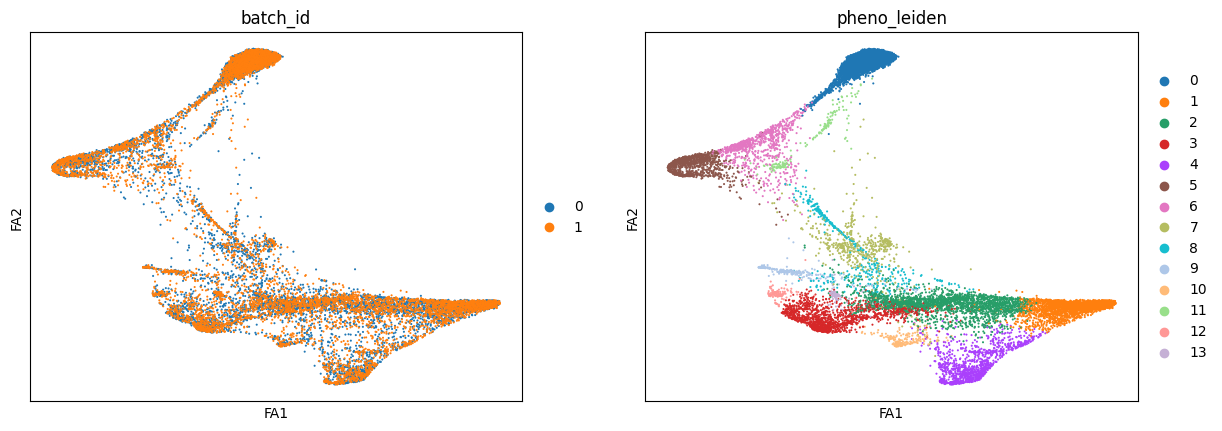

In [37]:
sc.pl.draw_graph(adata, color = ['batch_id', 'pheno_leiden'])

In [38]:
adata.obs.columns

Index(['batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo',
       'pheno_leiden'],
      dtype='object')

In [39]:
df_temp = pd.DataFrame({'pheno_leiden': adata.obs['pheno_leiden'], 
                        '%-Mito': adata.obs['pct_counts_mt'], 
                        'library_size': adata.obs['log1p_total_counts'], 
                        'n_genes_per_cell': adata.obs['log1p_n_genes_by_counts']}, index = adata.obs.index)

/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_2164/693190300.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "pheno_leiden", y = "%-Mito", data = df_temp, ax = ax,
/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_2164/693190300.py:4: UserWarning: The palette list has more values (28) than needed (14), which may not be intended.
  sns.boxplot(x = "pheno_leiden", y = "%-Mito", data = df_temp, ax = ax,
/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_2164/693190300.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "pheno_leiden", y = "library_size", data = df_temp, ax = ax,
/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_2164/693190300

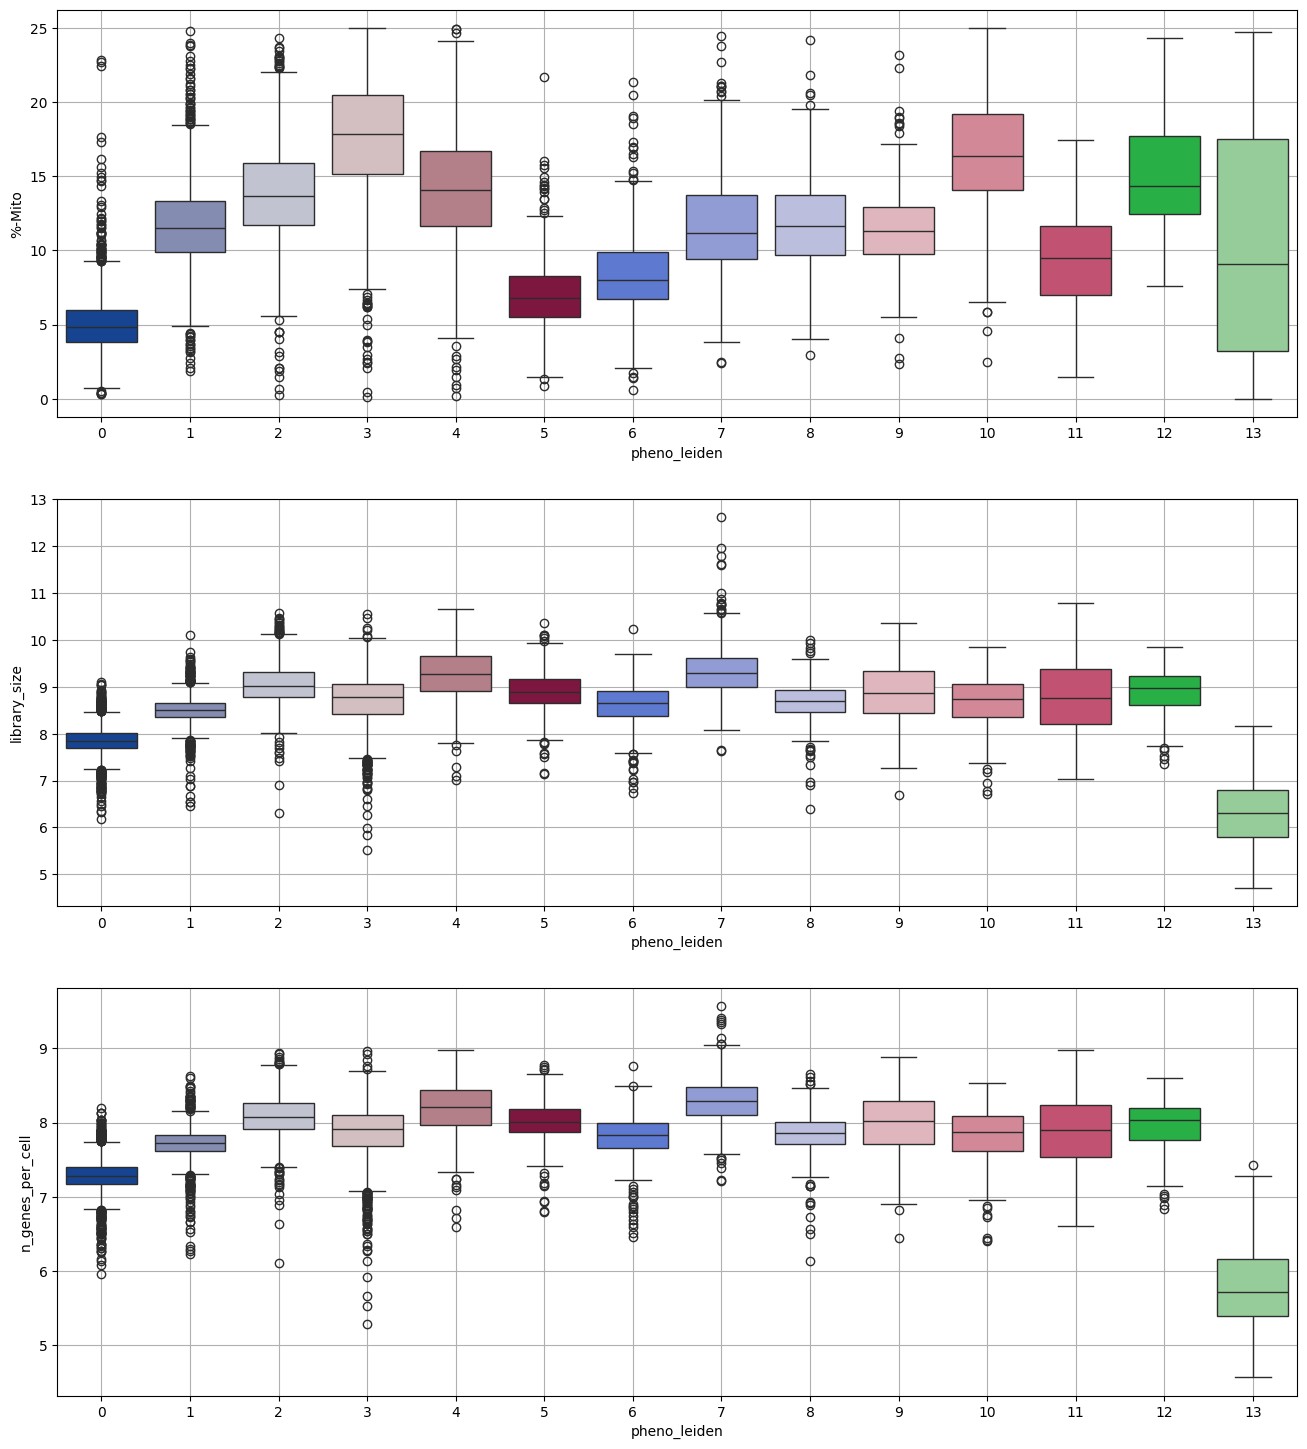

In [40]:
import seaborn as sns
fig = plt.figure(figsize = (8*2, 6*3))
ax = fig.add_subplot(3, 1, 1)
sns.boxplot(x = "pheno_leiden", y = "%-Mito", data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')

ax = fig.add_subplot(3, 1, 2)
sns.boxplot(x = "pheno_leiden", y = "library_size", data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')

ax = fig.add_subplot(3, 1, 3)
sns.boxplot(x = "pheno_leiden", y = "n_genes_per_cell", data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')


# 6. Doublet Detection using Scrublet

In [41]:
adata_scrublet = sc.AnnData(adata.layers['raw_data'], obs = adata.obs, var = adata.var)

In [42]:
sc.external.pp.scrublet(adata_scrublet, sim_doublet_ratio=2.0, expected_doublet_rate=0.06, 
                        knn_dist_metric='euclidean', log_transform=True, n_prin_comps=30, 
                        random_state=0)

/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


In [43]:
adata_scrublet

AnnData object with n_obs × n_vars = 13350 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'scrublet'

In [45]:
adata_scrublet.obs[['doublet_score', 'predicted_doublet']]

,doublet_score,predicted_doublet
AAACAGCCACCTGTAA-1-0,0.044068,False
AAACAGCCACTCGCTC-1-0,0.023681,False
AAACAGCCACTGACCG-1-0,0.024221,False
AAACAGCCATAATCAC-1-0,0.047157,False
AAACATGCAAATTCGT-1-0,0.033774,False
...,...,...
TTTGTGTTCGTCAAGT-1-1,0.072548,False
TTTGTGTTCTAACTGA-1-1,0.121495,False
TTTGTGTTCTCAATTC-1-1,0.092414,False
TTTGTTGGTTCGCTCA-1-1,0.103864,False


In [46]:
adata_scrublet.uns['scrublet']

{'doublet_scores_sim': array([0.37193764, 0.3037037 , 0.32374101, ..., 0.3037037 , 0.34631433,
        0.06246719]),
 'doublet_parents': array([[ 9762,  6435],
        [ 8908,  3117],
        [10219,  9182],
        ...,
        [ 8837,  7103],
        [10827,  3116],
        [12805, 11992]]),
 'parameters': {'expected_doublet_rate': 0.06,
  'sim_doublet_ratio': 2.0,
  'n_neighbors': 58,
  'random_state': 0},
 'threshold': 0.19416957306608706}

In [47]:
adata.obs[['doublet_score', 'predicted_doublet']] = adata_scrublet.obs[['doublet_score', 'predicted_doublet']]
adata.uns['scrublet'] = adata_scrublet.uns['scrublet']

In [48]:
adata.obs['predicted_doublet'] = adata.obs['predicted_doublet'].astype('category')

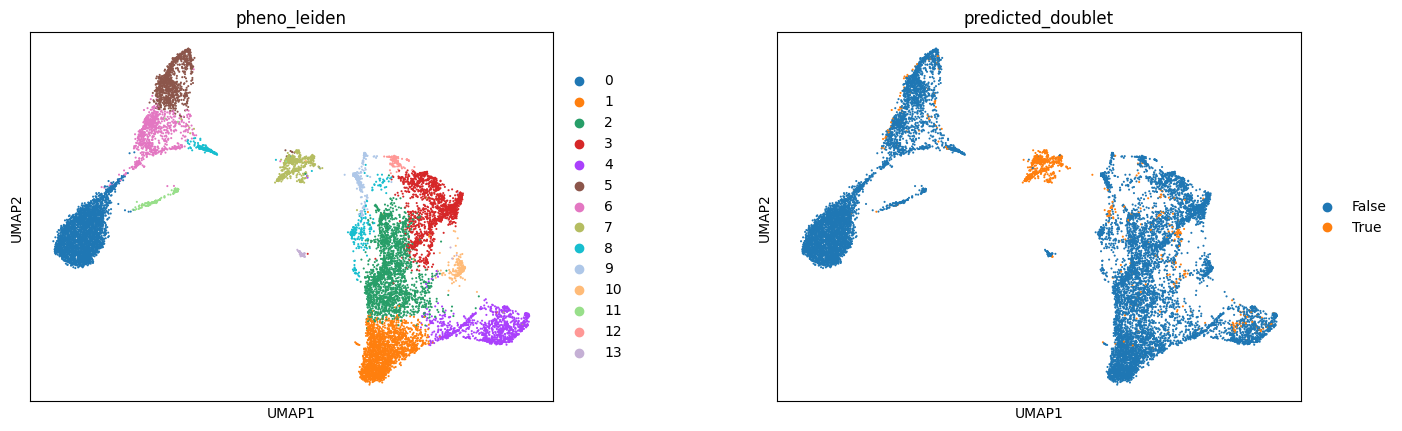

In [49]:
sc.pl.umap(adata, color = ['pheno_leiden', 'predicted_doublet'], wspace = 0.3)

In [50]:
df_temp = pd.DataFrame({'pheno_leiden': adata.obs['pheno_leiden'], 
                        'Doublet Score': adata.obs['doublet_score']}, index = adata.obs.index)

/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_2164/3096494409.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "pheno_leiden", y = "Doublet Score", data = df_temp, ax = ax,
/var/folders/mt/d2m12d815dxgmwddkyzp9bpc0000gn/T/ipykernel_2164/3096494409.py:3: UserWarning: The palette list has more values (28) than needed (14), which may not be intended.
  sns.boxplot(x = "pheno_leiden", y = "Doublet Score", data = df_temp, ax = ax,


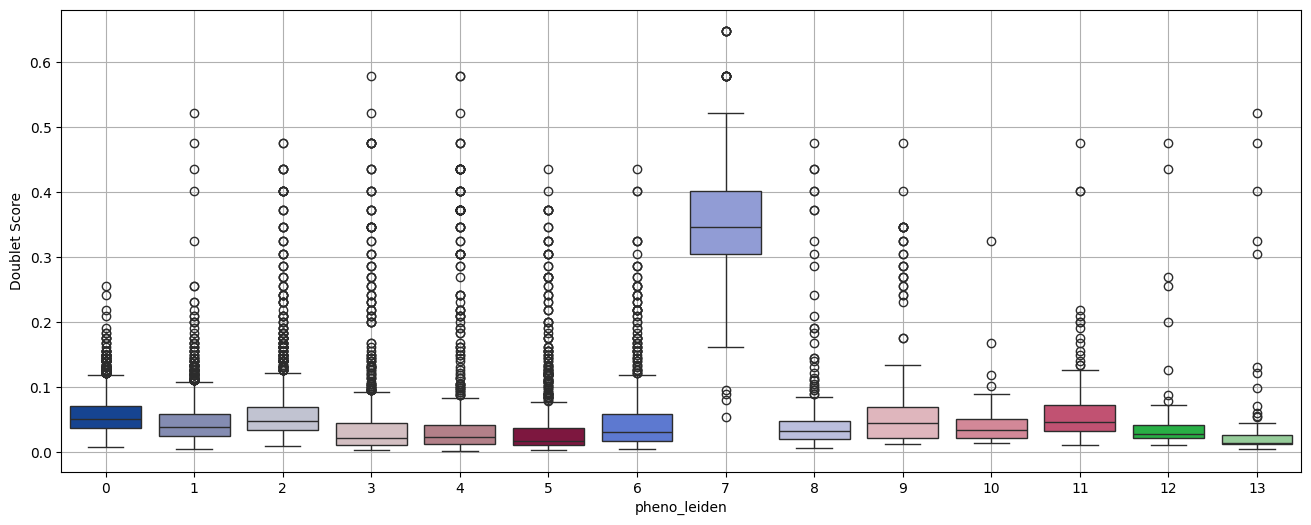

In [51]:
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x = "pheno_leiden", y = "Doublet Score", data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')

In [52]:
# remove cluster 7
adata_clean_rm7 = adata[~adata.obs['pheno_leiden'].isin([7]), :].copy()

In [53]:
adata_clean_rm7

AnnData object with n_obs × n_vars = 12824 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'draw_graph', 'pheno_jaccard_q', 'batch_id_colors', 'pheno_leiden_colors', 'scrublet', 'predicted_doublet_colors'
    obsm: 'X_pca', 'X_umap', 'umap_30_knn', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'raw_data', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

In [54]:
adata_clean_rm7.write_h5ad('/Users/sangeevanvellappan/Desktop/scRNA/processed_adata_doublet.h5ad')

## Next steps: iterate and redo preprocessing on cleaned data

In [55]:
adata_clean_rm7 = sc.read_h5ad('/Users/sangeevanvellappan/Desktop/scRNA/processed_adata_doublet.h5ad')

In [56]:
# HVG
sc.pp.highly_variable_genes(adata_clean_rm7, layer = 'raw_data', n_top_genes=2500, flavor='seurat_v3')

# PCA
sc.tl.pca(adata_clean_rm7, n_comps=50, use_highly_variable=True)

# Neighbors
sc.pp.neighbors(adata_clean_rm7, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')

# UMAP
sc.tl.umap(adata_clean_rm7, min_dist=0.1, neighbors_key='neighbors_30')

# PhenoGraph clustering
sc.external.tl.phenograph(adata_clean_rm7, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter=1)

adata_clean_rm7.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adata_clean_rm7.obsp['pheno_jaccard_ig'])

/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.630821943283081 seconds
Jaccard graph constructed in 4.27170205116272 seconds
Running Leiden optimization
Leiden completed in 3.2553179264068604 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 9.610604047775269 seconds


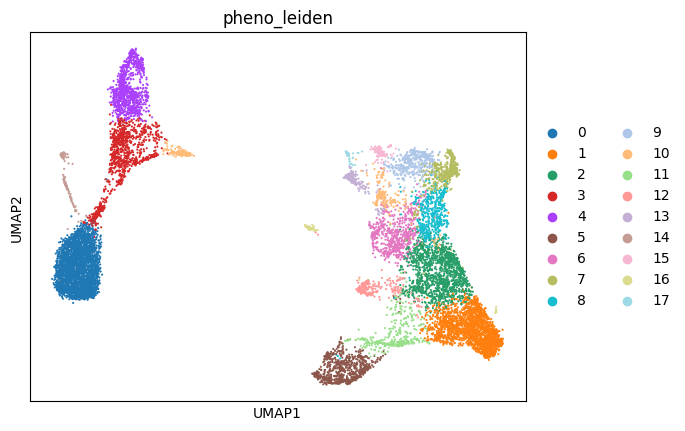

In [57]:
sc.pl.umap(adata_clean_rm7, color = ['pheno_leiden'])

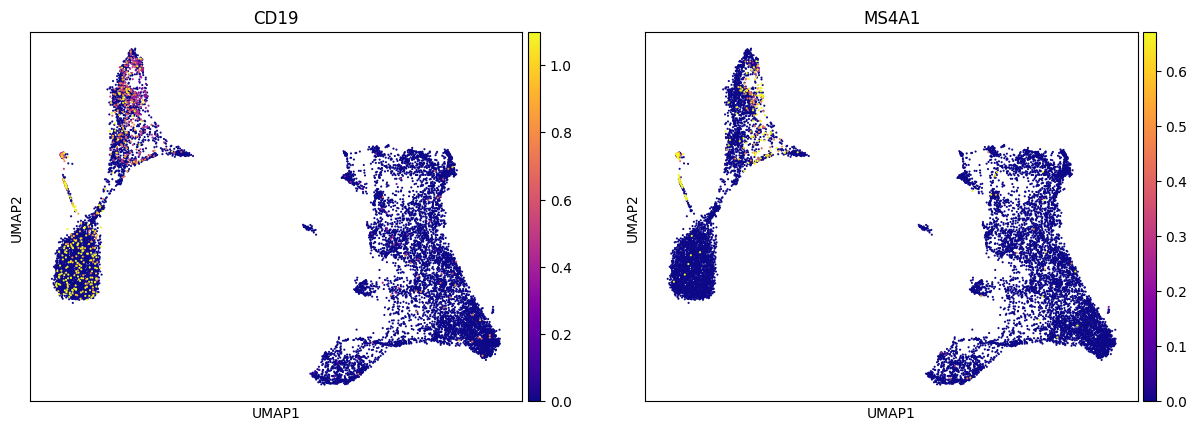

In [58]:
genes = ['CD19', 'MS4A1']
sc.pl.umap(adata_clean_rm7, color = genes, cmap = 'plasma', ncols = 3, use_raw=False, vmin = 'p1', vmax = 'p99')

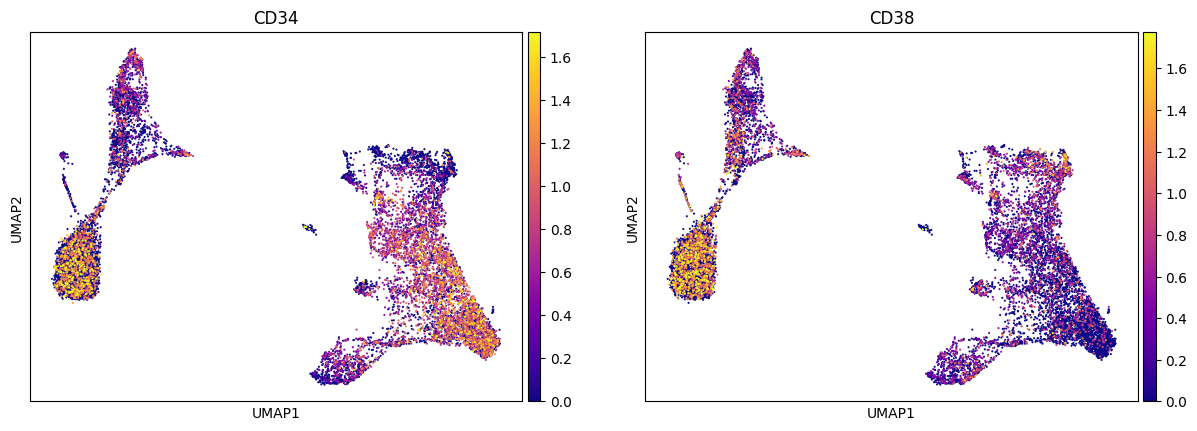

In [59]:
genes = ['CD34', 'CD38']
sc.pl.umap(adata_clean_rm7, color = genes, cmap = 'plasma', ncols = 3, use_raw=False, vmin = 'p1', vmax = 'p99')

In [60]:
genes_to_exclude = ['CD19', 'MS4A1']

In [61]:
# Filter out the specified genes
genes_to_keep = ~adata_clean_rm7.var_names.isin(genes_to_exclude)
adata_filtered = adata_clean_rm7[:, genes_to_keep]


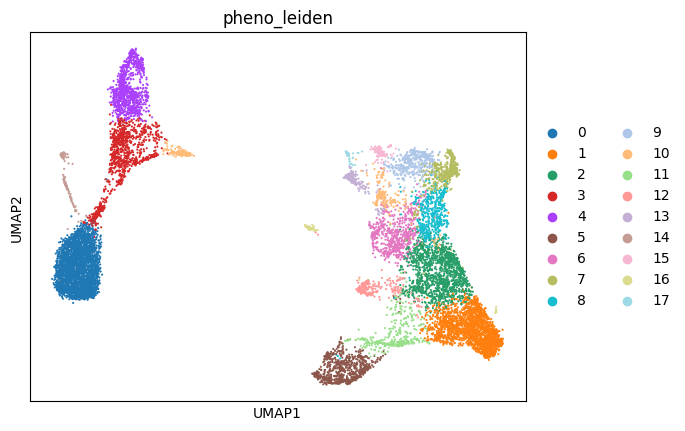

In [62]:
sc.pl.umap(adata_filtered, color = ['pheno_leiden'])

In [63]:
# Filter genes to include only CD19 and MS4A1
genes_of_interest = ['CD34']
adata_filtered2 = adata_filtered[:, adata_filtered.var_names.isin(genes_of_interest)]


In [64]:
import scipy

In [65]:
# PhenoGraph clustering
sc.external.tl.phenograph(adata_filtered2, clustering_algo='leiden', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter=1)

adata_filtered2.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adata_filtered2.obsp['pheno_jaccard_ig'])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.4316380023956299 seconds
Jaccard graph constructed in 5.774535179138184 seconds
Running Leiden optimization
Leiden completed in 5.885590076446533 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 13.79096508026123 seconds


/Users/sangeevanvellappan/anaconda3/envs/workshop_2024_v2/lib/python3.9/site-packages/scanpy/external/tl/_phenograph.py:275: ImplicitModificationWarning: Setting element `.obsp['pheno_jaccard_ig']` of view, initializing view as actual.
  adata.obsp[ig_key] = graph.tocsr()


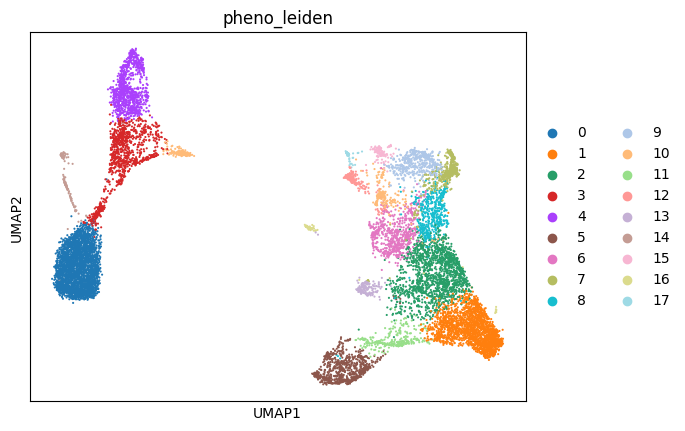

In [66]:
sc.pl.umap(adata_filtered2, color = ['pheno_leiden'])

In [67]:
adata_filtered2

AnnData object with n_obs × n_vars = 12824 × 1
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'batch_id_colors', 'draw_graph', 'hvg', 'log1p', 'neighbors_30', 'pca', 'pheno_jaccard_q', 'pheno_leiden_colors', 'predicted_doublet_colors', 'scrublet', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap', 'umap_30_knn'
    varm: 'PCs'
    layers: 'norm_counts', 'raw_data'
    obsp: 'neighbors_30_connectivities', 'neighbors_30_distances', 'pheno_jaccard_ig'

In [69]:
genes = {'HSPC': ['CD34', 'CD38'], 
         'CLP-B_cell_lineage': ['CD79B', 'EBF1', 'PAX5'], 
         'Mature_B_cell_marker': ['CD19', 'MS4A1', 'EBF1'], 
         'Erythroid_lineage': ['GATA1'], 
         'DC_lineage': ['IRF8'], 
         'Monocyte_lineage': ['MPO'],
        'Megakaryocyte': ['ITGA2B'], 
         'BMCP': ['HDC', 'MS4A2']}


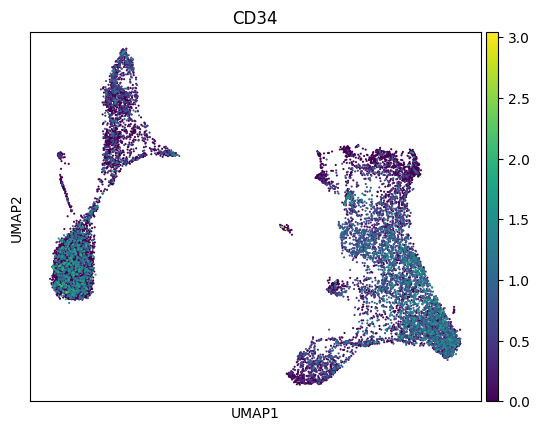

In [70]:
sc.pl.umap(adata_filtered, color = 'CD34')

Text(0, 0.5, 'Clusters')

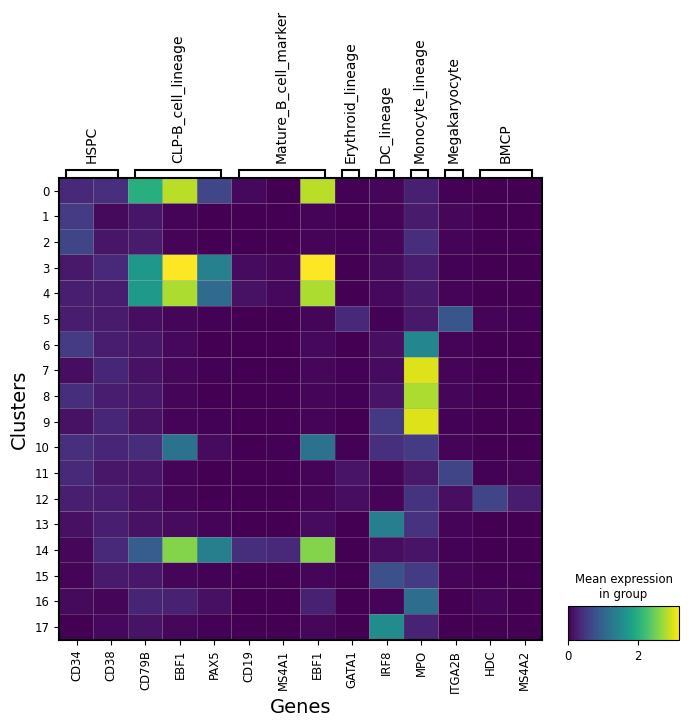

In [71]:
ax = sc.pl.matrixplot(adata_clean_rm7, genes, groupby = 'pheno_leiden', show = False, figsize = (8, 6), use_raw = False)
ax['mainplot_ax'].set_xlabel('Genes', fontsize = 14)
ax['mainplot_ax'].set_ylabel('Clusters', fontsize = 14)

In [73]:

adata_clean_rm8 = adata_clean_rm7[~adata_clean_rm7.obs['pheno_leiden'].isin([0,3,4,10, 7,14]), :].copy()

map_dictionary = {0: 'CLP-B', 
                  1: 'HSPC',
                  2: 'HSPC',
                  3: 'CLP-B',
                  4:'CLP-B', 
                  5:'Monocyte', 
                  6:'Monocyte', 
                  7:'Monocyte',
                  8:'Monocyte', 
                  9:'Monocyte', 
                  10:'CLP-B', 
                  11:'Megakary', 
                  12:'DC', 
                  13:'BMCP', 
                  14:'CLP-B',
                  15:'Monocyte', 
                  16:'Monocyte', 
                  17:'DC'}
adata_clean_rm8.obs['celltype'] = adata_clean_rm8.obs['pheno_leiden'].map(map_dictionary)

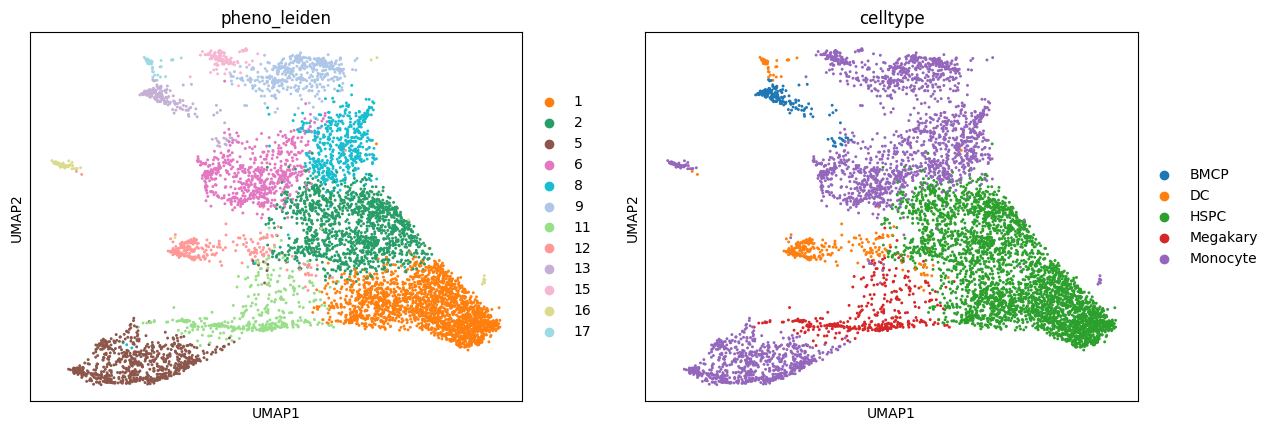

In [74]:
# here we have the figure 1 a and e plotted... looks similar, may be not exact? 
sc.pl.umap(adata_clean_rm8, color = ['pheno_leiden', 'celltype'])

In [75]:
#let me also try to work on the trajectory and pick the starting point
cell_barcodes_1 = adata_clean_rm8.obs.index[adata_clean_rm8.obs['pheno_leiden'] == 1]

In [76]:
import random
start_cell = random.sample(list(cell_barcodes_1), 1)
start_cell[0]

'GGTACTTAGGTCGATT-1-1'

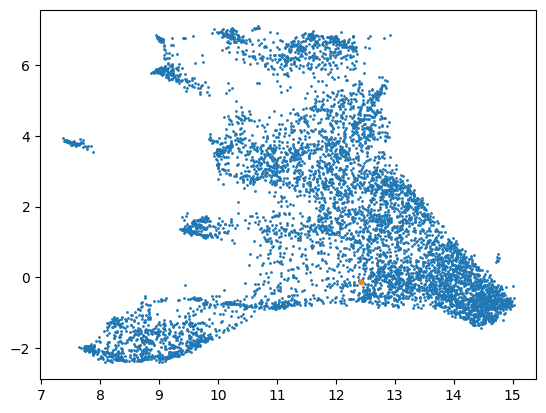

In [77]:
#the below we have the starting point...i need to figure out how to proceed with the terminal state...
plt.scatter(adata_clean_rm8.obsm['X_umap'][:, 0], adata_clean_rm8.obsm['X_umap'][:, 1], s = 1)
loc_start = adata_clean_rm8.obs.index.get_loc(start_cell[0])
plt.scatter(adata_clean_rm8.obsm['X_umap'][loc_start, 0], adata_clean_rm8.obsm['X_umap'][loc_start, 1], s = 10)

In [78]:
adata_clean_rm8

AnnData object with n_obs × n_vars = 6750 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet', 'celltype'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'batch_id_colors', 'draw_graph', 'hvg', 'log1p', 'neighbors_30', 'pca', 'pheno_jaccard_q', 'pheno_leiden_colors', 'predicted_doublet_colors', 'scrublet', 'umap', 'celltype_colors'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap', 'umap_30_knn'
    varm: 'PCs'
    layers: 'norm_counts', 'raw_data'
    obsp: 'neighbors_30_connectivities', 'neighbors_30_distances', 'pheno_jaccard_ig'

# Scanpy inbuilt diffusion maps

In [79]:
import palantir

In [80]:
palantir.utils.run_diffusion_maps(adata_clean_rm8, n_components=50);

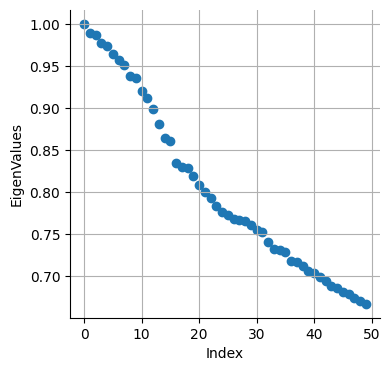

In [81]:
# visualize the eigenvalues:
plt.scatter(range(len(adata_clean_rm8.uns['DM_EigenValues'])), adata_clean_rm8.uns['DM_EigenValues'])
plt.xlabel('Index')
plt.ylabel('EigenValues')
plt.grid('on')

In [82]:
palantir.utils.determine_multiscale_space(adata_clean_rm8);

In [83]:
adata_clean_rm8.obsm['DM_EigenVectors_multiscaled'].shape

(6750, 15)

In [84]:
adata_clean_rm8

AnnData object with n_obs × n_vars = 6750 × 17810
    obs: 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pheno_leiden', 'doublet_score', 'predicted_doublet', 'celltype'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'batch_id_colors', 'draw_graph', 'hvg', 'log1p', 'neighbors_30', 'pca', 'pheno_jaccard_q', 'pheno_leiden_colors', 'predicted_doublet_colors', 'scrublet', 'umap', 'celltype_colors', 'DM_EigenValues'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap', 'umap_30_knn', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled'
    varm: 'PCs'
    layers: 'norm_counts', 'raw_data'
    obsp: 'neighbors_30_

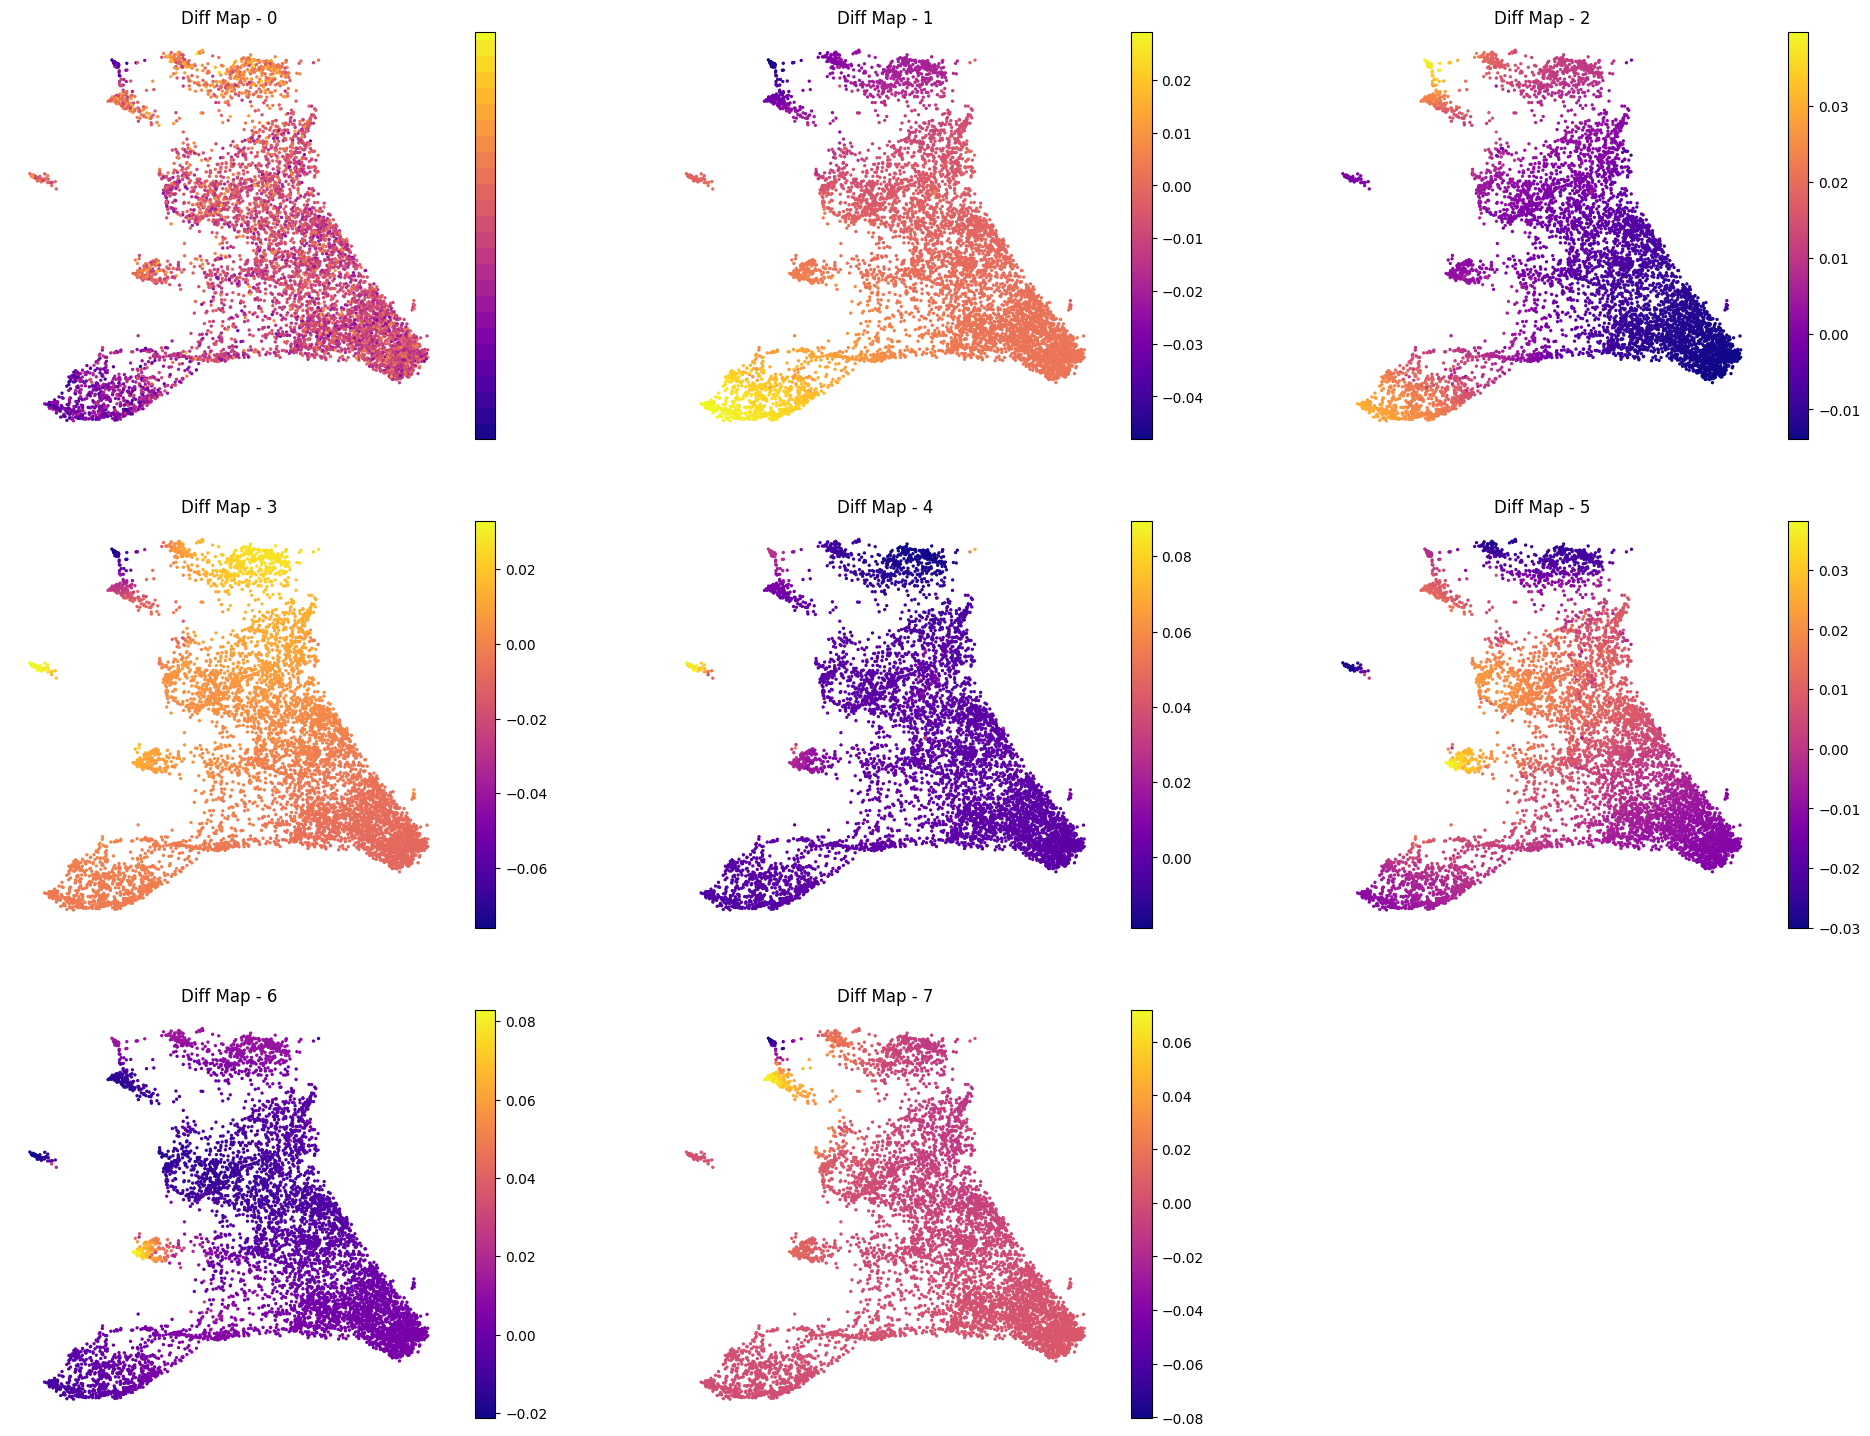

In [85]:
# Visualize the first 8 eigenvectors... i need to figure out how to proceed after this
ncol = 3
nrow = 3

fig = plt.figure(figsize = (8*ncol, 6*nrow))
for j in range(8):
    ax = fig.add_subplot(nrow, ncol, j + 1)
    im1 = ax.scatter(adata_clean_rm8.obsm['X_umap'][:, 0], adata_clean_rm8.obsm['X_umap'][:, 1], s = 2, 
                 c = adata_clean_rm8.obsm['DM_EigenVectors'][:, j], cmap = 'plasma')
    fig.colorbar(im1)
    ax.axis('off')
    ax.set_title('Diff Map - ' + str(j))
    
# To save: 
# fig.savefig(output_directory + 'umap_colored_by_diff_maps.png', bbox_inches = 'tight', dpi = 150)

i need to figure out how to proceed after this..I was able to recreate the Figures 1 a and e, but I am also interested in further showing the terminal states and compute pseudotime...work in progress..but this is good for now. 